In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

from eofs.xarray import Eof

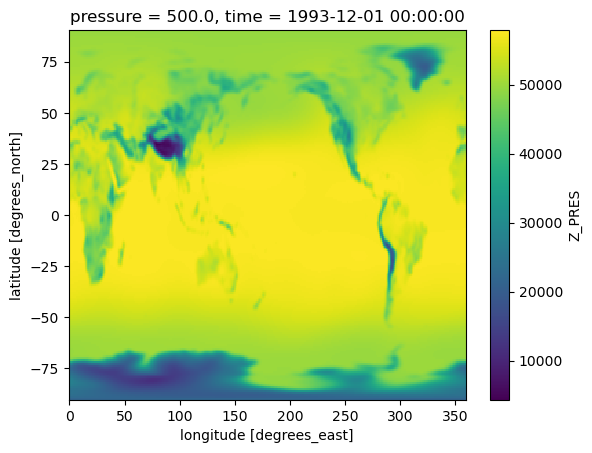

In [7]:
DS = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/1MS//CESM_1993-12_Pressure_Levels.nc')
DS['Z_PRES'].sel(pressure=500).squeeze().plot()

## Load Data

In [3]:
conc = []
for yryr in range(1979,2015):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['TREFHT', 'PRECT','PS']].resample(time='1D').mean().load()
print('... resampled and loaded ....')

FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/averaged_UVTQtotPSPRECTTREFHT*'))
DSs = xr.open_mfdataset(FNS)

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
doing 2014
... resampling and loading ....
... resampled and loaded ....


## PS EOFS ML Dataset 

In [6]:
DSps = DSs[['PS','PRECT','TREFHT']]
DSps_rolling = DSps.rolling(time=30, center=True, min_periods=1).mean().load()
DFJM_DSps_rolling = DSps_rolling.sel(time=DSps_rolling['time'].dt.month.isin([12, 1, 2, 3]))

DSps_cesm = DSzarr1_TP[['PS','PRECT','TREFHT']]
DSps_cesm_rolling = DSps_cesm.rolling(time=30, center=True, min_periods=1).mean().load()
DFJM_DSps_cesm_rolling = DSps_cesm_rolling.sel(time=DSps_cesm_rolling['time'].dt.month.isin([12, 1, 2, 3]))


## EOFS

EOF 1 started
EOF 1 done


/glade/derecho/scratch/wchapman/tmp/ipykernel_5730/997578333.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


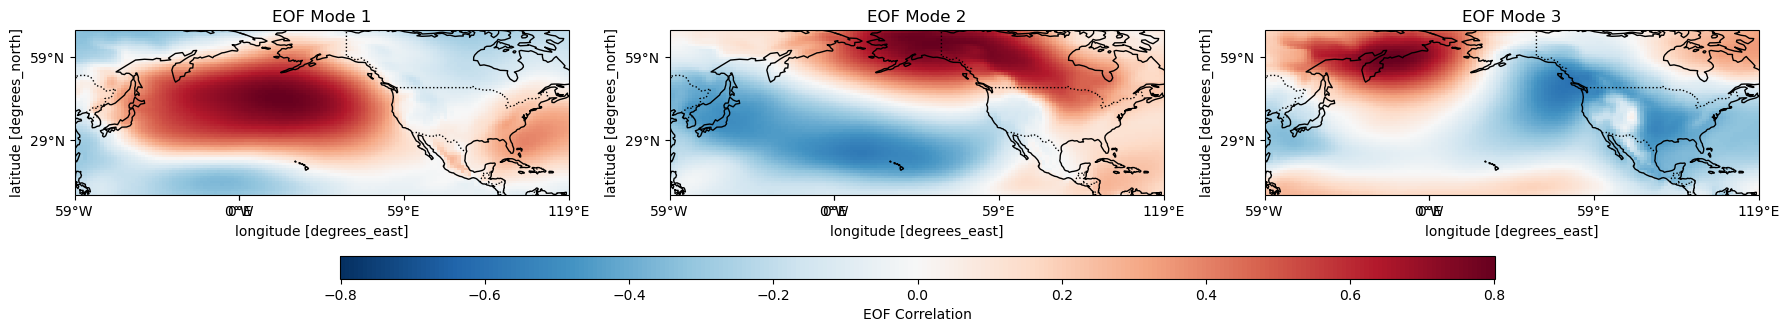

/glade/derecho/scratch/wchapman/tmp/ipykernel_5730/997578333.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


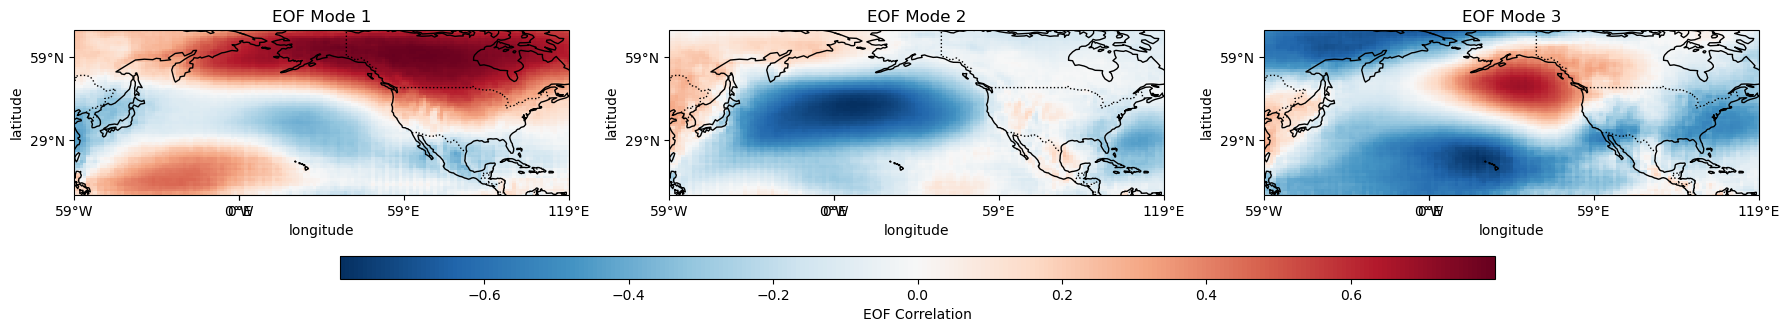

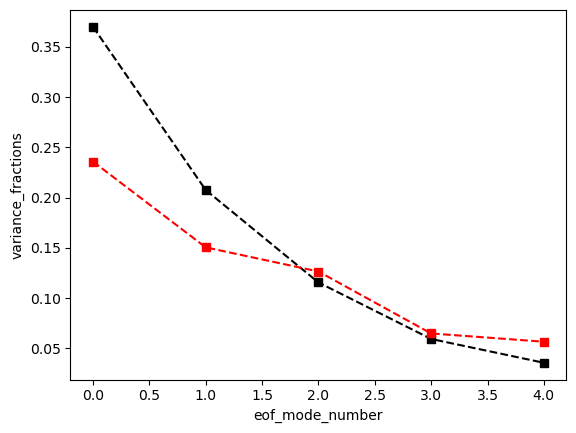

In [18]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DFJM_DSps_rolling['PS'].sel(latitude=slice(0, 70), longitude=slice(120, 300))

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

print('EOF 1 started')
# Perform EOF analysis
solver2 = Eof(PS, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc2 = solver2.pcs(npcs=3, pcscaling=1)
print('EOF 1 done')
# Assuming PS is already calculated from the dataset DS_lens
PS = DFJM_DSps_cesm_rolling['PS'].sel(latitude=slice(0, 70), longitude=slice(120, 300))

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = -1*eof2.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

solver1.varianceFraction(neigs=5).plot(color='k',linestyle='--',marker='s')
solver2.varianceFraction(neigs=5).plot(color='r',linestyle='--',marker='s')
plt.show()

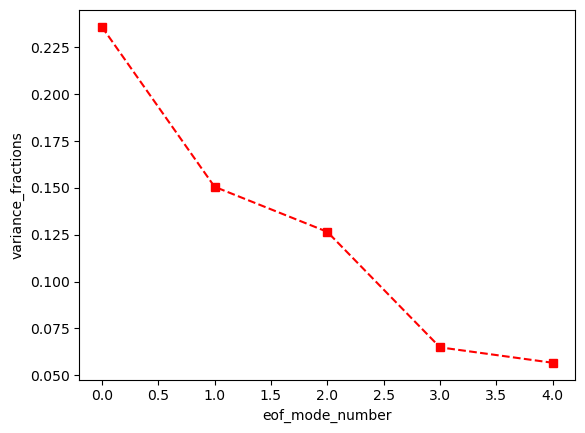

In [14]:
solver2.varianceFraction(neigs=5).plot(color='r',linestyle='--',marker='s')
plt.show()

## Stream Function Modes of Var

In [22]:
DSmerged = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/SF_VP_524mb_and_associates.nc')
DScesm_merged = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191/1981-01-02T00Z/1D/SF_VP_CESM_524mb_and_associates.nc')

DSps = DSmerged[['stream_function','vorticity']]
DSps_rolling = DSps.rolling(time=30, center=True, min_periods=1).mean().load()
DFJM_DSps_rolling = DSps_rolling.sel(time=DSps_rolling['time'].dt.month.isin([12, 1, 2, 3]))

DSps_cesm = DScesm_merged[['stream_function','vorticity']]
DSps_cesm_rolling = DSps_cesm.rolling(time=30, center=True, min_periods=1).mean().load()
DFJM_DSps_cesm_rolling = DSps_cesm_rolling.sel(time=DSps_cesm_rolling['time'].dt.month.isin([12, 1, 2, 3]))


/glade/derecho/scratch/wchapman/tmp/ipykernel_5730/165035759.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


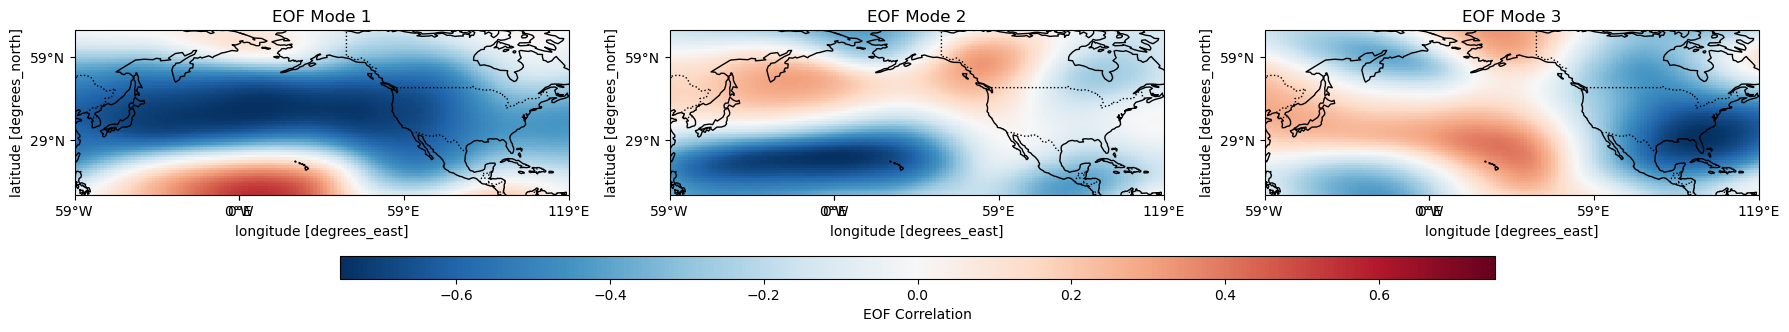

/glade/derecho/scratch/wchapman/tmp/ipykernel_5730/165035759.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


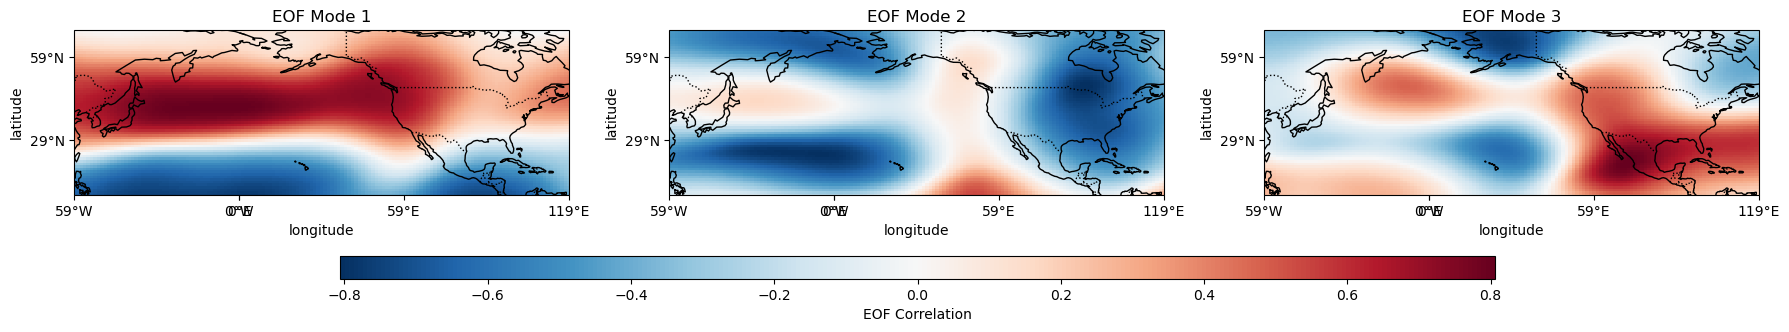

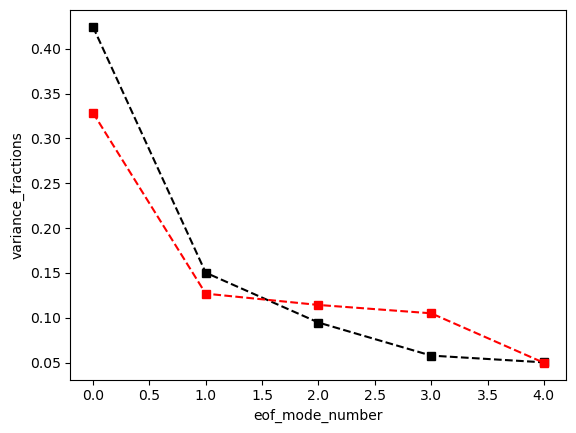

In [26]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DFJM_DSps_rolling['stream_function'].sel(latitude=slice(0, 70), longitude=slice(120, 300))

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

print('EOF 1 started')
# Perform EOF analysis
solver2 = Eof(PS, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc2 = solver2.pcs(npcs=3, pcscaling=1)
print('EOF 1 done')
# Assuming PS is already calculated from the dataset DS_lens
PS = DFJM_DSps_cesm_rolling['stream_function'].sel(latitude=slice(0, 70), longitude=slice(120, 300))

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)


# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = -1*eof2.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

solver1.varianceFraction(neigs=5).plot(color='k',linestyle='--',marker='s')
solver2.varianceFraction(neigs=5).plot(color='r',linestyle='--',marker='s')
plt.show()